In [2]:
import sys


In [3]:
sys.path.append('/root/gpt-circuits')

In [18]:
import torch as t
import torch.nn as nn
from torch import Tensor
from torch.autograd.functional import jacobian
import os

from safetensors.torch import save_file, load_file

import einops

from models.gpt import GPT
from models.sparsified import SparsifiedGPT, SparsifiedGPTOutput

from config.gpt.training import options
from config.sae.models import sae_options

from data.tokenizers import ASCIITokenizer, TikTokenTokenizer

from models.sae import SparseAutoencoder
from typing import Callable

from data.dataloaders import TrainingDataLoader
TensorFunction = Callable[[Tensor], Tensor]

import matplotlib.pyplot as plt
import numpy as np

In [8]:
ig1 = load_file('data/standard_staircase_attributionsV1.safetensors')

In [9]:
ig2 = load_file('data/standard_staircase_attributionsV2.safetensors')

In [87]:
ma1 = load_file('data/manual_ablation1.safetensors')

In [88]:
ma2 = load_file('data/manual_ablation2.safetensors')

In [15]:
ma2.keys()

dict_keys(['0-1 occurences', '0-1 scores', '1-2 occurences', '1-2 scores', '2-3 occurences', '2-3 scores', '3-4 occurences', '3-4 scores'])

tensor([9.2205e-01, 8.6627e+01, 5.6665e-01, 1.7461e+00, 6.7645e-01, 1.7038e-01,
        4.5306e-01, 9.5307e+01, 1.3985e+02, 9.8631e+00, 2.1820e-01, 7.9013e-01,
        3.8170e-01, 4.0283e-01, 2.3866e+00, 2.1326e-01, 3.1253e-01, 2.5196e+00,
        2.7405e+01, 1.3207e+00, 4.3514e+01, 4.7461e+01, 9.4618e-01, 8.9713e-01,
        5.8587e-01, 1.3772e+00, 2.9531e-01, 5.3231e+01, 7.4354e-01, 1.6137e+01,
        6.3537e+01, 2.8569e+01, 1.1173e+00, 1.0577e+02, 1.1103e+02, 8.8138e-01,
        1.2363e+02, 5.0932e-01, 5.1462e+00, 4.1827e+01, 6.4013e+01, 5.5485e+01,
        5.9687e-01, 9.7478e-01, 1.0302e+02, 8.5362e+01, 6.2119e+01, 1.9823e+00,
        6.2546e+01, 1.0244e+01, 7.6985e-01, 2.5711e+00, 1.2407e+00, 1.0906e+00,
        4.1834e+01, 3.3887e+00, 4.1338e+00, 7.8290e+01, 3.0876e+01, 4.9887e-01,
        1.5421e+00, 3.2157e+00, 1.7973e+00, 1.2278e+00, 1.0637e+00, 3.5839e+01,
        1.1438e+00, 1.4498e+02, 1.7421e+02, 4.9105e-01, 4.6609e-01, 9.4845e-01,
        1.7453e+00, 1.4424e+02, 1.6877e+

In [142]:
def compare_tensors_scatter(tensor1, tensor2, xlabel='Tensor 1 Values', ylabel='Tensor 2 Values', title='Tensor Comparison'):
    """
    Scatter plot comparison of two n x n tensors.
    
    Parameters:
        tensor1 (np.ndarray): First n x n tensor.
        tensor2 (np.ndarray): Second n x n tensor.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): Title of the plot.
    """
    # Ensure inputs are NumPy arrays
    tensor1 = np.asarray(tensor1)
    tensor2 = np.asarray(tensor2)
    
    if tensor1.shape != tensor2.shape:
        raise ValueError("Tensors must have the same shape.")
    
    # Flatten tensors
    x = tensor1.flatten()
    y = tensor2.flatten()
    
    # Create scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, alpha=0.6, s=5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

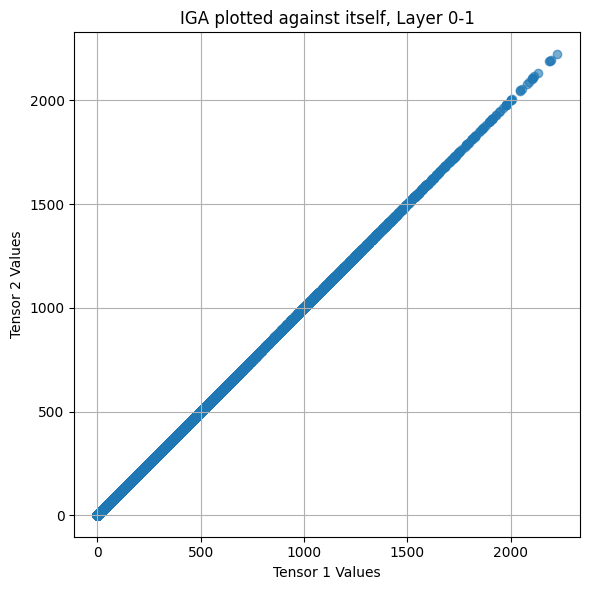

In [19]:
key = '0-1'
compare_tensors_scatter(ig1[key], ig2[key], title='IGA plotted against itself, Layer 0-1')

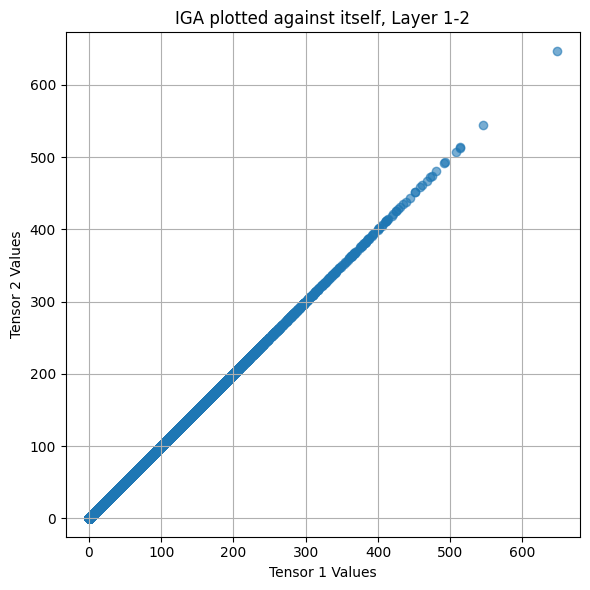

In [24]:
key = '1-2'
compare_tensors_scatter(ig1[key], ig2[key], title='IGA plotted against itself, Layer 1-2')

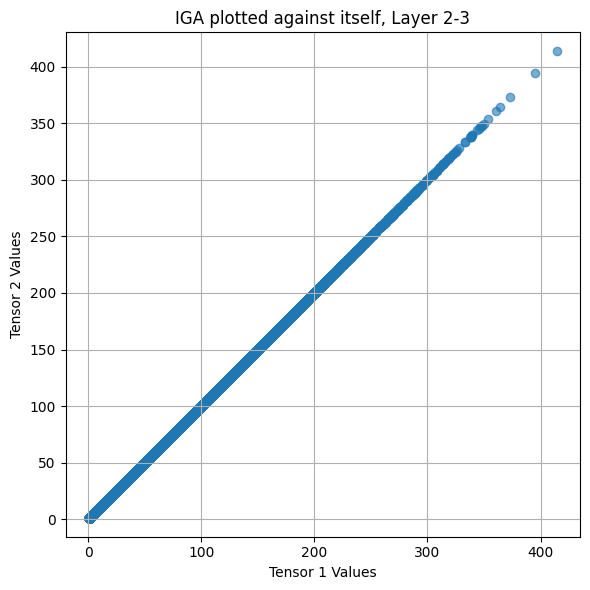

In [25]:
key = '2-3'
compare_tensors_scatter(ig1[key], ig2[key], title='IGA plotted against itself, Layer 2-3')

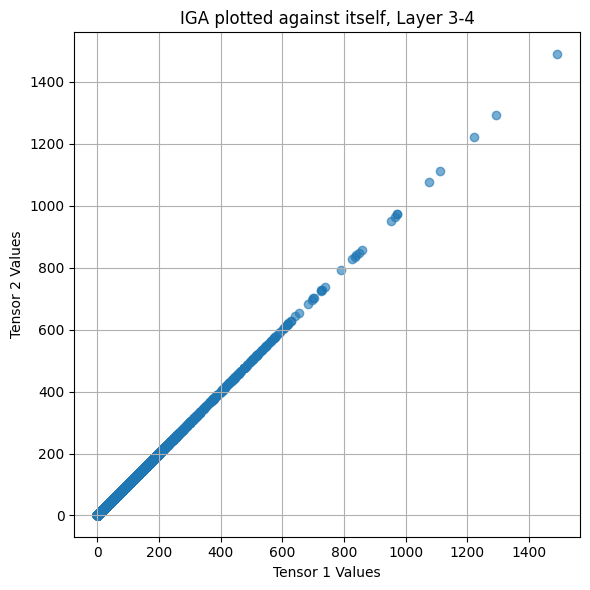

In [26]:
key = '3-4'
compare_tensors_scatter(ig1[key], ig2[key], title='IGA plotted against itself, Layer 3-4')

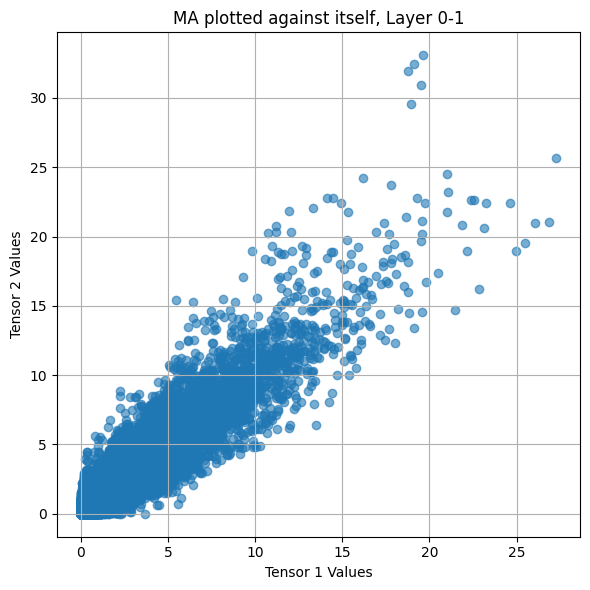

In [89]:
key = '0-1 scores'
compare_tensors_scatter(ma1[key], ma2[key], title='MA plotted against itself, Layer 0-1')

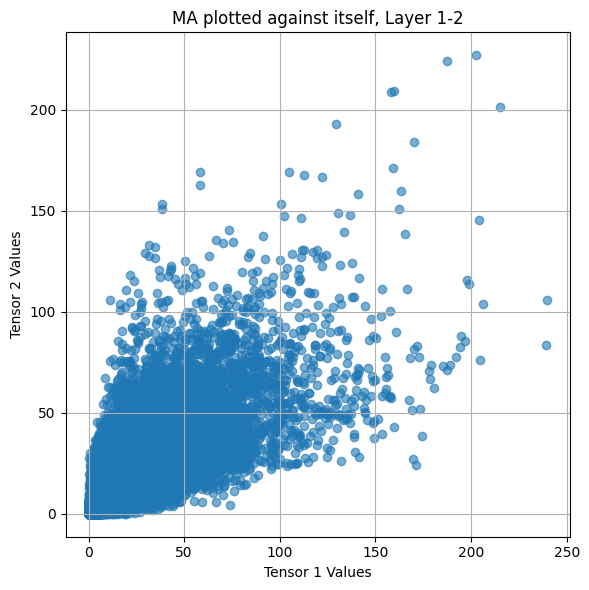

In [90]:
key = '1-2 scores'
compare_tensors_scatter(ma1[key], ma2[key], title='MA plotted against itself, Layer 1-2')

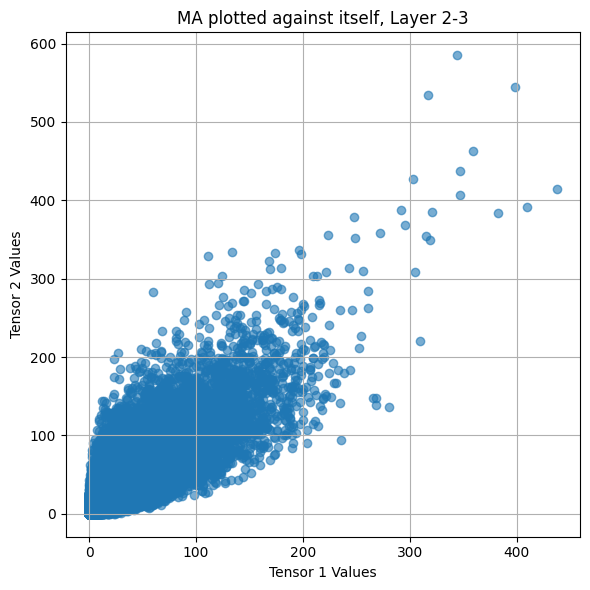

In [91]:
key = '2-3 scores'
compare_tensors_scatter(ma1[key], ma2[key], title='MA plotted against itself, Layer 2-3')

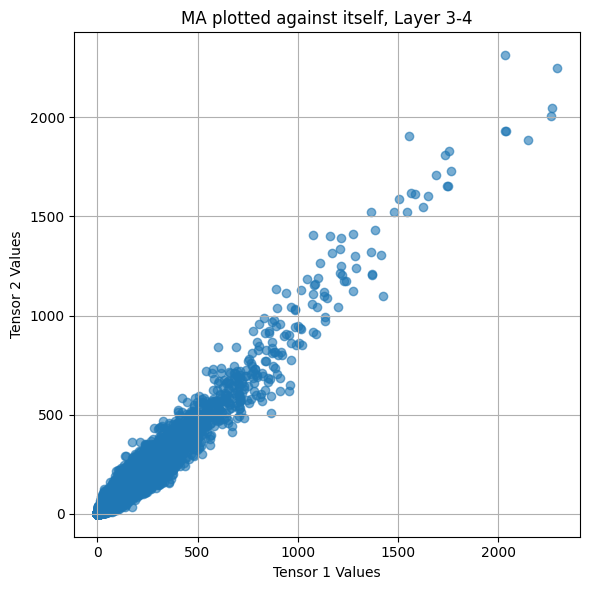

In [92]:
key = '3-4 scores'
compare_tensors_scatter(ma1[key], ma2[key], title='MA plotted against itself, Layer 3-4')

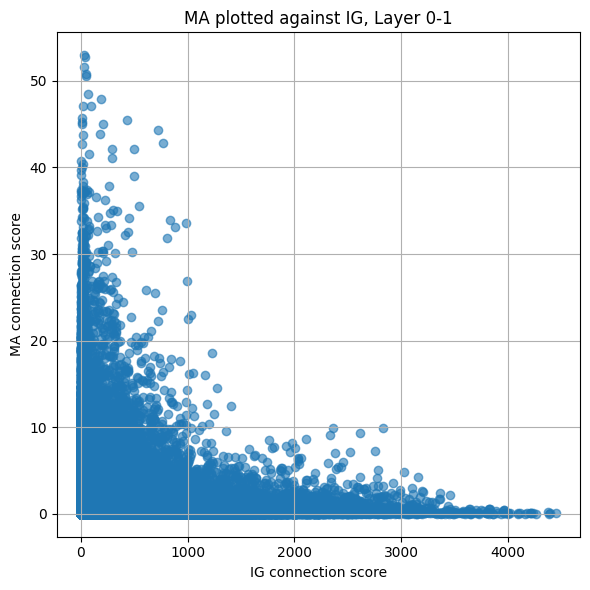

In [93]:
key = '0-1'
compare_tensors_scatter(ig1[key] + ig2[key], ma1[f'{key} scores'] + ma2[f'{key} scores'], title=f'MA plotted against IG, Layer {key}', xlabel='IG connection score', ylabel= 'MA connection score')

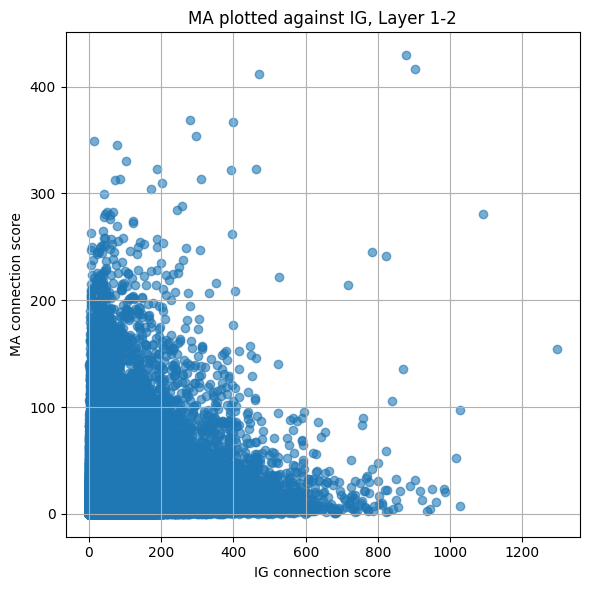

In [94]:
key = '1-2'
compare_tensors_scatter(ig1[key] + ig2[key], ma1[f'{key} scores'] + ma2[f'{key} scores'], title=f'MA plotted against IG, Layer {key}', xlabel='IG connection score', ylabel= 'MA connection score')

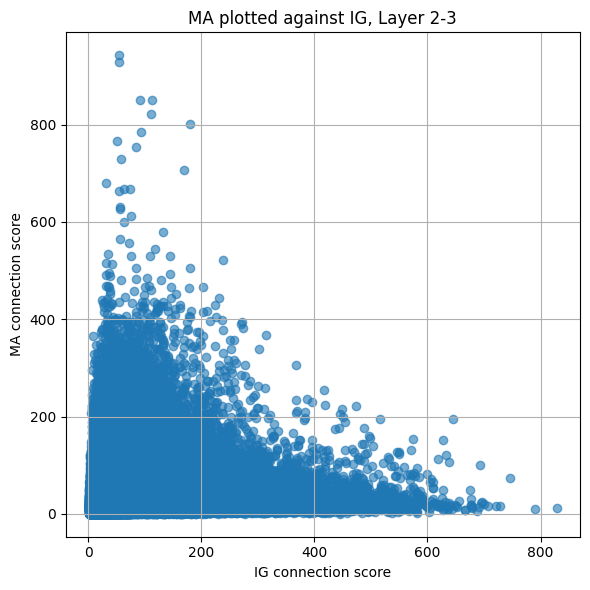

In [95]:
key = '2-3'
compare_tensors_scatter(ig1[key] + ig2[key], ma1[f'{key} scores'] + ma2[f'{key} scores'], title=f'MA plotted against IG, Layer {key}', xlabel='IG connection score', ylabel= 'MA connection score')

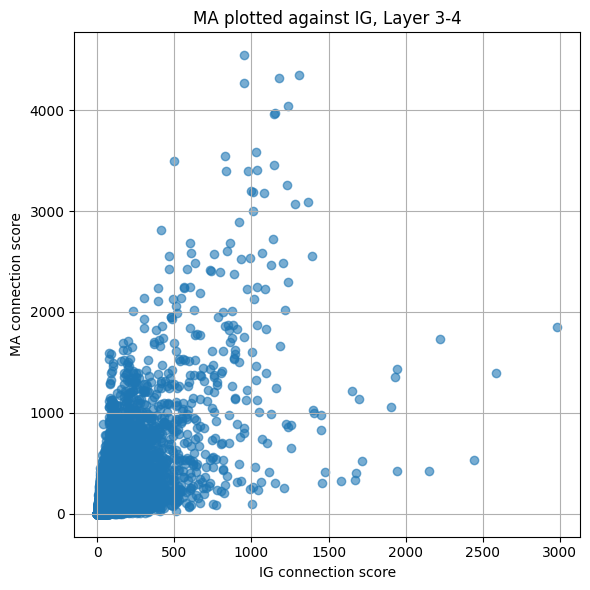

In [96]:
key = '3-4'
compare_tensors_scatter(ig1[key] + ig2[key], ma1[f'{key} scores'] + ma2[f'{key} scores'], title=f'MA plotted against IG, Layer {key}', xlabel='IG connection score', ylabel= 'MA connection score')

In [111]:
ma1_34_mask = ma1['3-4 occurences'].sum(dim = 0) != 0

In [117]:
ma_34_scales = ma1['3-4 occurences'].sum(dim = 0)[ma1_34_mask]
ma_34_scaled = ma1['3-4 scores'][ma1_34_mask, :] / ma_34_scales[:, None]

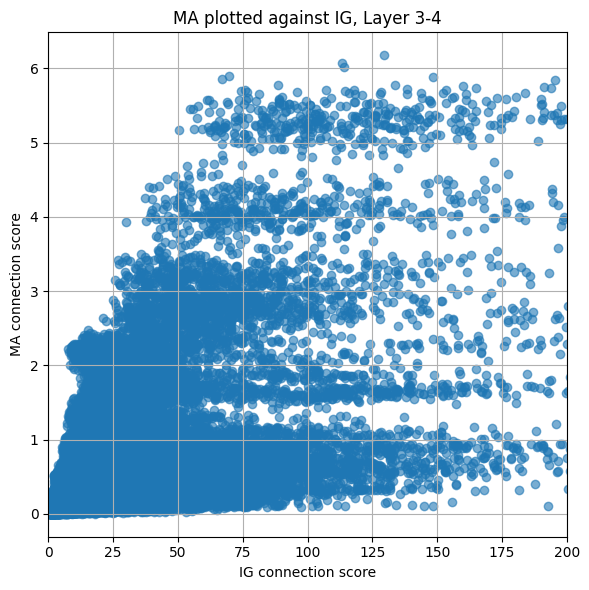

In [121]:
compare_tensors_scatter(ig1['3-4'][ma1_34_mask, :], ma_34_scaled, title=f'MA plotted against IG, Layer 3-4', xlabel='IG connection score', ylabel= 'MA connection score')

In [137]:
def scale_by_occurence(key, mas):
    mask = mas[f'{key} occurences'].sum(dim = 0) != 0
    
    scales = (mas[f'{key} occurences']*t.arange(128, 0, -1)[:, None]).sum(dim = 0)[mask]
    scaled = mas[f'{key} scores'][mask, :] / scales[:, None]
    return scaled, mask

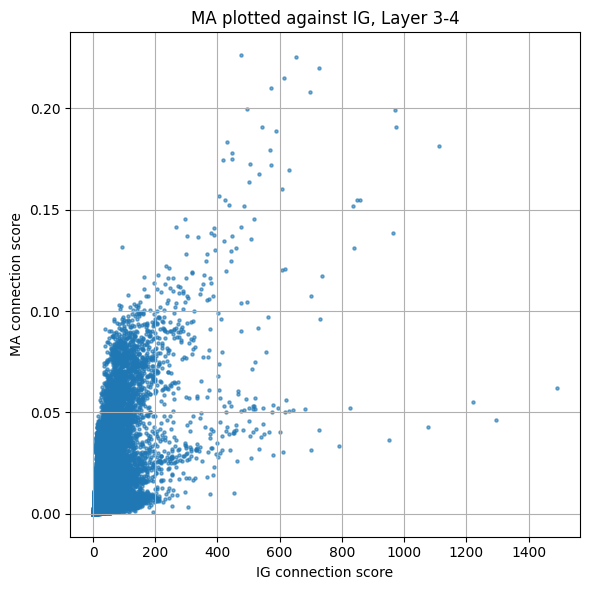

In [146]:
key = '3-4'
scaled, mask = scale_by_occurence(key, ma1)
compare_tensors_scatter(ig1[key][mask, :] , scaled, title=f'MA plotted against IG, Layer {key}', xlabel='IG connection score', ylabel= 'MA connection score')

In [133]:
t.arange(10, 0, -1)

tensor([10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [136]:
ma1['3-4 occurences'].shape

torch.Size([128, 512])